In [95]:
import xarray as xr
import numpy as np
import hydromt
from os.path import join, basename, isfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from hydromt_sfincs import SfincsModel
import pandas as pd
import glob

In [96]:
def skill(da_sim, da_obs, da_msk, hmin=0.15):
    sim = da_sim>hmin
    obs = da_obs>0  # assume obs is binary mask of extent

    ds = xr.Dataset(dict(
        true_pos = np.logical_and(sim, obs),
        false_neg = np.logical_and(~sim, obs),
        false_pos = np.logical_and(sim, ~obs),
    )).where(~da_msk,False)
    
    ntot = np.logical_or(sim, obs).where(~da_msk,False).sum(('x', 'y'))
    nobs = obs.where(~da_msk,False).sum(('x', 'y'))
    nsim = sim.where(~da_msk,False).sum(('x', 'y'))
    
    hit_rate = ds['true_pos'].sum(('x', 'y')) / nobs
    false_rate = ds['false_pos'].sum(('x', 'y')) / nsim
    csi = ds['true_pos'].sum(('x', 'y')) / ntot
    bias = ds['false_pos'].sum(('x', 'y')) / ds['false_neg'].sum(('x', 'y'))
    da_skill = xr.merge([csi.rename('C'), hit_rate.rename('H'), false_rate.rename('F'), bias.rename('E')])
    
    # true negative and mask are both 0
    da_cm = (ds['true_pos']*3+ds['false_pos']*2+ds['false_neg']*1).astype(np.uint8)
    da_cm.raster.set_crs(da_sim.raster.crs)
    da_cm.raster.set_nodata(da_sim.raster.crs)
        
    return da_skill, da_cm

In [ ]:
mod0 = SfincsModel('../02_models/beira/sfincs/03_01_htot_dis_precip', mode='r', deltares_data=True)
mod1 = SfincsModel('../02_models/beira/sfincs/03_07_htide_disclim_precip', mode='r', deltares_data=True)
trange = slice('20190313T0000','20190324T0000')
event = 'idai'

In [160]:
mod1.forcing['bzs'].max('time')

<xarray.DataArray 'bzs' (index: 3)>
array([5.45, 5.49, 5.3 ])
Coordinates:
  * index        (index) int32 1 2 3
    x            (index) float64 6.842e+05 6.874e+05 6.967e+05
    y            (index) float64 7.788e+06 7.804e+06 7.804e+06
    spatial_ref  int32 1

<xarray.DataArray 'bzs' ()>
array(-0.21)
Coordinates:
    index        int32 2
    x            float64 6.874e+05
    y            float64 7.804e+06
    spatial_ref  int32 1


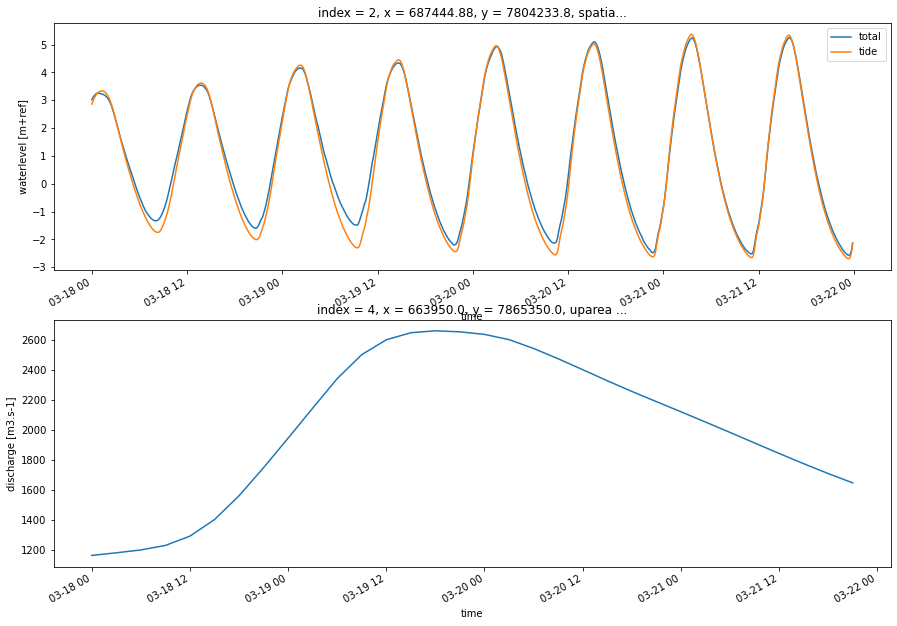

In [185]:
fig, (ax, ax1) = plt.subplots(2,1, figsize=(15,10))
# (mod0.forcing['bzs']-mod1.forcing['bzs']).plot.line(x='time', ax=ax)

tslice = slice('20190318', '20190321')
mod0.forcing['dis'].isel(index=3).sel(time=tslice).plot.line(x='time', ax=ax1)
mod0.forcing['bzs'].isel(index=1).sel(time=tslice).plot.line(x='time', ax=ax, label='total')
mod1.forcing['bzs'].isel(index=1).sel(time=tslice).plot.line(x='time', ax=ax, label='tide')
ax.legend()
print((mod0.forcing['bzs']-mod1.forcing['bzs']).isel(index=1).sel(time=tslice).min('time'))
# ax.set_ylim([3.5, 4])

In [4]:
grwl_mask = mod0.data_catalog.get_rasterdataset('grwl_mask', geom=mod0.region, buffer=10).raster.reproject_like(mod0.staticmaps)
riv_mask = np.logical_or(mod0.staticmaps['rivmsk']>0, grwl_mask>0)
dep_mask = mod0.staticmaps['dep']==-9999
da_mask = np.logical_or(dep_mask, riv_mask)
# riv_mask.plot()

In [158]:
mod0 = SfincsModel('../02_models/beira/sfincs/03_11_htot_dis_precip', mode='r', deltares_data=True)
mod1 = SfincsModel('../02_models/beira/sfincs/03_17_htide_disclim_precip', mode='r', deltares_data=True)
trange = slice('20210118T0000','20210128T0000')
event = 'eloise'

In [ ]:
# mod0.read_config()
# mod0.read_forcing()
# geom_style = {
#     "msk2": dict(linestyle="-", linewidth=3, color="y"),
#     "msk3": dict(linestyle="-", linewidth=3, color="orangered"),
# }
# mod0.plot_basemap(geoms=['bnd', 'src'], geom_kwargs=geom_style)

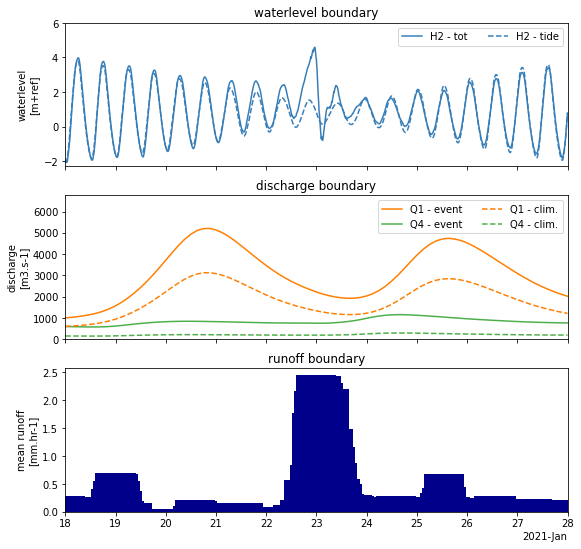

In [159]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
forcing = mod0.forcing
kwargs=dict()

colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

n = len(forcing.keys())
kwargs0 = dict(sharex=True, figsize=(9, n * 3))
kwargs0.update(**kwargs)
fig, axes = plt.subplots(n, 1, **kwargs0)
axes = [axes] if n == 1 else axes
for i, name in enumerate(forcing):
    da = forcing[name].sel(time=trange)
    longname = da.attrs.get("standard_name", "")
    unit = da.attrs.get("unit", "")
    prefix = ""
    if da.ndim == 3:
        da = da.mean(dim=[da.raster.x_dim, da.raster.y_dim])
        prefix = "mean "
    # convert to Single index dataframe (bar plots don't work with xarray)
    df = da.squeeze().to_series()
    if isinstance(df.index, pd.MultiIndex):
        df = df.unstack(0)
    # convert dates a-priori as automatic conversion doesn't always work
    df.index = mdates.date2num(df.index)
    if longname == "precipitation":
        axes[i].bar(df.index, df.values, facecolor="darkblue")
        longname = 'runoff'
    else:
        # tide / disclim
        da1 = mod1.forcing[name].sel(time=trange)
        df1 = da1.squeeze().to_series().unstack(0)
        df1.index = mdates.date2num(df1.index)
        
        bound = 'H' if longname == 'waterlevel' else 'Q'
        cols = [1] if longname == 'waterlevel' else [0,3]
        ylim = [df.values.min()*1.05, df.values.max()*1.3] if longname == 'waterlevel' else [0, df.values.max()*1.3]
        j0 = 0 if longname == 'waterlevel' else 1
        
        # plot actual
        suffix = 'tot' if longname == 'waterlevel' else 'event'
        df.columns = [f'{bound}{i} - {suffix}' for i in df.columns.values]
        for j, col in enumerate(df.columns[cols]):
            df.loc[:,col].plot.line(ax=axes[i], c=colors[j+j0], label=col)
            
        # plot tide/clim
        suffix = 'tide' if longname == 'waterlevel' else 'clim.'
        df1.columns = [f'{bound}{i} - {suffix}' for i in df1.columns.values]
        for j, col in enumerate(df1.columns[cols]):
            df1.loc[:,col].plot.line(ax=axes[i], ls='--', color=colors[j+j0], label=col)


        axes[i].legend(
#             title="index",
            bbox_to_anchor=(1, 1),
            loc="upper right",
            ncol=2,
        )
        axes[i].set_ylim(ylim)

    axes[i].set_ylabel(f"{prefix}{longname}\n[{unit}]")
    axes[i].set_title(f"{longname} boundary")
    axes[i].set_xlim([df.index[0], df.index[-1]])

# use a concise date formatter for format date axis ticks
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
axes[-1].xaxis.set_major_locator(locator)
axes[-1].xaxis.set_major_formatter(formatter)

plt.savefig(join('figs', f'forcing_{event}.png'), dpi=225, bbox_inches="tight")

### preprocess EO data

In [ ]:
# ddir = r'..\00_data\EO\RAPID\Cyclone_Idai_2019'
ddir = r'..\00_data\EO\RAPID\Cyclone_Eloise_2021'
name = 'flooding'
dstr = '20210125'
fns = glob.glob(join(ddir, dstr, f'{name}*.tif'))

da_lst = []
for fn in fns:
    da_obs0 = hydromt.open_raster(fn).load().astype(np.int8)
    da_obs0.raster.set_nodata(-1)
#     try:
    da_obs0 = da_obs0.raster.reproject_like(mod0.staticmaps, method='max')
    da_lst.append(da_obs0)
#     except:
#         print(fn)
#         pass
    
da = xr.concat(da_lst, dim='img').max('img').load().astype(np.uint8)
da = da.where(da==1,0)
da.raster.set_nodata(0)
da.raster.to_raster(join(mod0.root, '../EO', f'{name.lower()}_{dstr}.tif'), compress='deflate')

In [ ]:
dstr = '20210125'

da_lst = []
for fn in glob.glob(join(mod0.root, '../EO', f'flooding_{dstr}*.tif')):
    da_lst.append(hydromt.open_raster(fn).astype(np.int8))
da_flood = xr.concat(da_lst, dim='img').max('img')

da_lst = []
for fn in glob.glob(join(mod0.root, '../EO', f'dry_{dstr}*.tif')):
    da_lst.append(hydromt.open_raster(fn).astype(np.int8))
if da_lst:
    da_dry = xr.concat(da_lst, dim='img').max('img')
    da_flood = da_flood.where(da_dry!=1, 0)
    
da_flood = da_flood.astype(np.uint8)
da_flood.raster.set_nodata(0)
da_flood.raster.to_raster(join(mod0.root, '../EO', f'flooding1_{dstr}_resampled_corrected.tif'), compress='deflate')

### read preprocessed EO data

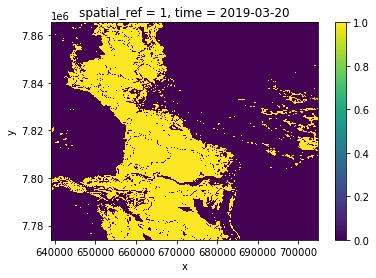

In [9]:
da_lst = []
dates = ['20190320', '20210125']
for dstr in dates:
    fn = join(mod0.root, '../EO', f'flooding_{dstr}_resampled_corrected.tif')
    da_obs0 = hydromt.open_raster(fn, chunks={'x': -1, 'y':-1}).load()
    da_obs = da_obs0.where(~da_mask, da_obs0.raster.nodata) == 1
    da_lst.append(da_obs)
da_obs = xr.concat(da_lst, dim='time')
da_obs['time'] = xr.IndexVariable('time', pd.to_datetime(dates))
da_obs.isel(time=0).plot()

In [10]:
import os
import pandas as pd
import cartopy.io.img_tiles as cimgt

cm_dict = {
    1: ('false neg.', '#dd8452'),
    2: ('false pos.', '#c44e52'),
    3: ('true pos.', '#4c72b0'),
}
levels = [k for k,v in cm_dict.items()] + [4]
colors = [v[1] for k,v in cm_dict.items()]
ticklabs = [v[0] for k,v in cm_dict.items()]
cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)
ticks = np.array(levels[:-1])+np.diff(levels)/2.

## compare CMF and SFINCS river bed levels

In [5]:
ds_cmf = hydromt.open_mfraster(r'../02_models/beira/cmf/beira_06min/*.tif')
ds_cmf.raster.set_crs(4326)

nodata value missing for ../02_models/beira/cmf/beira_06min\col.tif
nodata value missing for ../02_models/beira/cmf/beira_06min\row.tif


In [6]:
import geopandas as gpd
colrows = [(25,30), (27,30), (26, 25), (26,26), (28,28)]
cols, rows = zip(*colrows)
cols = xr.IndexVariable('index', np.asarray(cols)-1)
rows = xr.IndexVariable('index', np.asarray(rows)-1)
xs, ys = ds_cmf.isel(x=cols, y=rows)['lonlat'].values
gdf_pnts = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=xs, y=ys), crs=4326)
gdf_pnts.index = gdf_pnts.index+1
gdf_pnts

,geometry
1,POINT (34.45958 -19.88542)
2,POINT (34.67542 -19.90042)
3,POINT (34.53625 -19.49958)
4,POINT (34.53292 -19.61375)
5,POINT (34.77875 -19.80208)


In [ ]:
ds_cmf0 = ds_cmf.isel(x=cols, y=rows)
ds_cmf0_zb = ds_cmf0['elevtn'] - ds_cmf0['rivdph_est_hc27_hp30']
ds_cmf0_zb.values

In [ ]:
mod0.staticmaps['dep'].raster.sample(gdf_pnts).load()

### read CMF flood maps


In [7]:
# read downscaled flood depth of all runs
da_lst = []
runs = []
event = 'idai'
for cmf_out in glob.glob(join('../02_models/beira/cmf/out', 'compound*')):
    if event == 'idai':
        da = xr.open_dataarray(join(cmf_out, event, 'flddph_20190310_20190325_3sec.nc'))
    else:
        da = xr.open_dataarray(join(cmf_out, event, 'flddph_20210118_20210201_3sec.nc'))
    da.raster.set_crs(4326)
    da = da.raster.reproject_like(mod0.staticmaps)
    da_lst.append(da.load())
    da.close()
    runs.append(basename(cmf_out).replace('compound_rivdph_est_',''))
da = xr.concat(da_lst, dim='run')
da['run'] = xr.IndexVariable('run', runs)
da.attrs.update(_FillValue=-9999)
encoding = {'flddph': {'zlib': True}}
da.to_netcdf(join('../02_models/beira/cmf/out', f'flddph_{event}_3sec.nc'))

In [98]:
event = 'eloise'
tstr = dates[1]
mdir = '../02_models/beira/cmf/out'
hmin=0.25
da = xr.open_dataarray(join(mdir, f'flddph_{event}_3sec.nc'))
da_skill, da_cm = skill(da.sel(time=tstr), da_obs.sel(time=tstr), da_mask, hmin=hmin)
df_skill = da_skill.reset_coords(drop=True).to_dataframe()
df_skill.to_csv(join(mdir, f'flddph_{event}_hmin{hmin}.csv'))
df_skill

,C,H,F,E
run,,,,
hc25_hp25,0.363117,0.451120,0.349481,0.441548
hc27_hp30,0.354149,0.425816,0.322144,0.352439
hc27_hp30_bifprm00,0.334312,0.412538,0.361917,0.398305
hc27_hp30_bifprm05,0.347072,0.414865,0.320109,0.333818
hc27_hp30_ro080,0.329838,0.384191,0.300173,0.267598
hc27_hp30_ro120,0.378726,0.479612,0.357086,0.511898
hc30_hp30,0.353286,0.422091,0.315730,0.337005
hc35_hp35,0.331144,0.385824,0.299710,0.268856
hc40_hp40,0.258456,0.294050,0.318963,0.195081


In [ ]:
sensitivities = {
    'bifprm': ['hc27_hp30_bifprm00', 'hc27_hp30_bifprm05', 'hc27_hp30'],
    'rivhgt': ['hc25_hp25', 'hc27_hp30', 'hc30_hp30', 'hc35_hp35', 'hc40_hp40'],
    'runoff': ['hc27_hp30_ro080', 'hc27_hp30', 'hc27_hp30_ro120'],
}
for s in sensitivities:
    rows = np.ceil(len(sensitivities[s])/3)
    da0 = da_cm.sel(run=sensitivities[s]).where(da_cm>0)
    cbar_kwargs = dict(shrink=0.5, ticks=ticks)
    obj = da0.plot(figsize=(15, 5*rows), cmap=cmap, norm=norm, add_colorbar=True, col='run', col_wrap=3, cbar_kwargs=cbar_kwargs)
    obj.cbar.ax.set_yticklabels(ticklabs)
    plt.savefig(join('../02_models/beira/cmf/out', f'flddph_{event}_{tstr}_{s}_3sec.png'), dpi=300)
    plt.close()

## read all SFINCS flood maps

In [15]:
mdir = r'../02_models/beira/sfincs/'
# IDAI runs < 10; eloise > 10
event, runs = 'idai', glob.glob(join(mdir, '02_0*')) + glob.glob(join(mdir, '03_0*'))
# event, runs = 'eloise', glob.glob(join(mdir, '02_1*')) + glob.glob(join(mdir, '03_1*'))

da_lst = []
names = []
for root in runs:
    mod = SfincsModel(root, mode='r')
    mod.read_results()
    da_hmax_fld = np.maximum(0, mod.results['zsmax'] - mod.results['zb']).rename({'timemax': 'time'})
#     da_hmax_fld = np.maximum(0, mod.results['zs'] - mod.results['zb']).resample(time='1D').max('time')
    da_lst.append(da_hmax_fld.rename('flddph'))
    names.append(basename(root)[6:])
    
da = xr.concat(da_lst, dim='run')
da['run'] = xr.IndexVariable('run', names)

encoding = {'flddph': {'zlib': True}}
da.to_netcdf(join(mdir, f'flddph_{event}.nc'))

In [121]:
mdir = r'../02_models/beira/sfincs/'
event = 'idai'
tstr = dates[0]
hmin=0.25
da = xr.open_dataarray(join(mdir, f'flddph_{event}.nc'))
da_skill, da_cm = skill(da.sel(time=tstr), da_obs.sel(time=tstr), da_mask, hmin=hmin)
df_skill = da_skill.reset_coords(drop=True).to_dataframe()
df_skill.to_csv(join(mdir, f'flddph_{event}_hmin{hmin}.csv'))
df_skill

,C,H,F,E
run,,,,
hc25_hp25_D4,0.725131,0.912452,0.220645,2.950675
hc30_hp30_D4,0.723978,0.906848,0.217856,2.711590
hc35_hp35_D4,0.721767,0.898788,0.214380,2.423244
hc40_hp40_D4,0.717051,0.888684,0.212191,2.150289
ro080,0.718943,0.879180,0.202238,1.844709
ro120,0.722773,0.925769,0.232763,3.783584
htot_dis_precip,0.724279,0.908172,0.218488,2.764928
htide_dis_noprecip,0.754081,0.894909,0.172655,1.777081
htot_disclim_noprecip,0.348839,0.376136,0.172214,0.125432


In [17]:
sensitivities = {
    'rivhgt': ['hc25_hp25_D4', 'htot_dis_precip', 'hc30_hp30_D4', 'hc35_hp35_D4', 'hc40_hp40_D4'],
    'runoff': ['ro080', 'htot_dis_precip', 'ro120'],
}
for s in sensitivities:
    rows = np.ceil(len(sensitivities[s])/3)
    da0 = da_cm.sel(run=sensitivities[s]).where(da_cm>0)
    cbar_kwargs = dict(shrink=0.5, ticks=ticks)
    obj = da0.plot(figsize=(15, 5*rows), cmap=cmap, norm=norm, add_colorbar=True, col='run', col_wrap=3, cbar_kwargs=cbar_kwargs)
    obj.cbar.ax.set_yticklabels(ticklabs)
    plt.savefig(join(mdir, f'flddph_{event}_zs_hmin{hmin}_{s}.png'), dpi=300)
    plt.close()
    

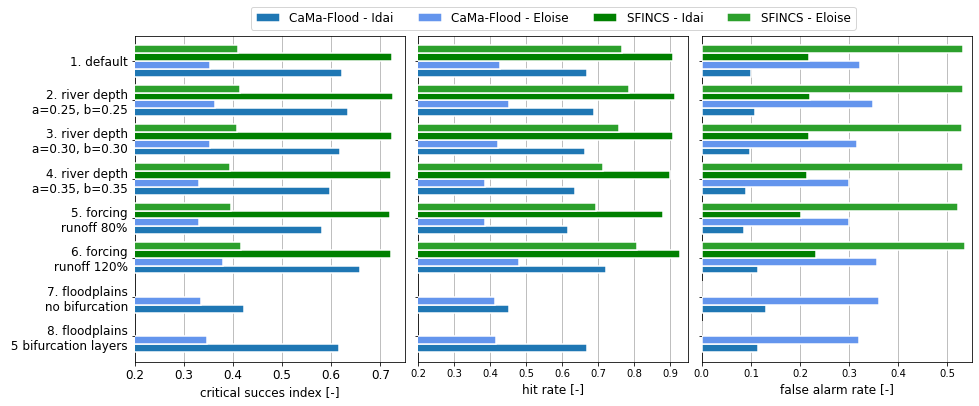

In [153]:
## barplots
sfx_rm = {
    'ro120': '6. forcing\n runoff 120%',
    'ro080': '5. forcing\n runoff 80%',
    'hc35_hp35_D4': '4. river depth\n a=0.35, b=0.35',
    'hc30_hp30_D4': '3. river depth\n a=0.30, b=0.30',
    'hc25_hp25_D4': '2. river depth\n a=0.25, b=0.25',
    'htot_dis_precip': '1. default',
}
cmf_rm = {
    'hc27_hp30_bifprm05': '8. floodplains\n 5 bifurcation layers',
    'hc27_hp30_bifprm00': '7. floodplains\n no bifurcation',
    'hc27_hp30_ro120': '6. forcing\n runoff 120%',
    'hc27_hp30_ro080': '5. forcing\n runoff 80%',
    'hc35_hp35': '4. river depth\n a=0.35, b=0.35',
    'hc30_hp30': '3. river depth\n a=0.30, b=0.30',
    'hc25_hp25': '2. river depth\n a=0.25, b=0.25',
    'hc27_hp30': '1. default',
}
event = 'idai'
sfx_skill = pd.read_csv(join(r'../02_models/beira/sfincs/', f'flddph_{event}_hmin{hmin}.csv'), index_col=0)
sfx_skill = sfx_skill.loc[sfx_rm.keys()].rename(sfx_rm)
cmf_skill= pd.read_csv(join(r'../02_models/beira/cmf/out/', f'flddph_{event}_hmin{hmin}.csv'), index_col=0)
cmf_skill = cmf_skill.loc[cmf_rm.keys()].rename(cmf_rm)
event = 'eloise'
sfx_skill1 = pd.read_csv(join(r'../02_models/beira/sfincs/', f'flddph_{event}_hmin{hmin}.csv'), index_col=0)
sfx_skill1 = sfx_skill1.loc[sfx_rm.keys()].rename(sfx_rm)
cmf_skill1= pd.read_csv(join(r'../02_models/beira/cmf/out/', f'flddph_{event}_hmin{hmin}.csv'), index_col=0)
cmf_skill1 = cmf_skill1.loc[cmf_rm.keys()].rename(cmf_rm)

csi = pd.concat([
    cmf_skill['C'].rename('CaMa-Flood - Idai'),
    cmf_skill1['C'].rename('CaMa-Flood - Eloise'),
    sfx_skill['C'].rename('SFINCS - Idai'), 
    sfx_skill1['C'].rename('SFINCS - Eloise'), 
], axis=1)
fr = pd.concat([
    cmf_skill['F'].rename('CaMa-Flood - Idai'),
    cmf_skill1['F'].rename('CaMa-Flood - Eloise'),
    sfx_skill['F'].rename('SFINCS - Idai'), 
    sfx_skill1['F'].rename('SFINCS - Eloise'), 
], axis=1)
hr = pd.concat([
    cmf_skill['H'].rename('CaMa-Flood - Idai'),
    cmf_skill1['H'].rename('CaMa-Flood - Eloise'),
    sfx_skill['H'].rename('SFINCS - Idai'), 
    sfx_skill1['H'].rename('SFINCS - Eloise'), 
], axis=1)
colors=['tab:blue', 'tab:purple', 'tab:green', 'tab:grey']
colors=['tab:blue', 'cornflowerblue', 'green', 'tab:green']

fig, axs = plt.subplots(1,3, figsize=(15,6), sharey=True)
kwargs = dict(color=colors, edgecolor='white', linewidth=1.5, width=0.8, legend=False, zorder=4)
fr.plot.barh(ax=axs[2], **kwargs)
hr.plot.barh(ax=axs[1], **kwargs).legend(
    bbox_to_anchor=(0.5, 1.0),
    loc="lower center",
    ncol=4,
    fontsize=12
)
csi.plot.barh(ax=axs[0], **kwargs)
axs[2].grid(axis='x')
axs[2].set_xlim([0,0.55])
axs[2].set_xlabel('false alarm rate [-]', fontsize=12)

axs[1].set_xlim([0.2, 0.95])
axs[1].set_xlabel('hit rate [-]', fontsize=12)
axs[1].grid(axis='x')

axs[0].set_xlim([0.2, 0.75])
axs[0].set_xlabel('critical succes index [-]', fontsize=12)
axs[0].set_ylabel('')
axs[0].tick_params(labelsize=12)
axs[0].grid(axis='x')

# fig.tight_layout()
fig.subplots_adjust(wspace=0.05) 
plt.savefig(join('figs', f'sensitivity_floodextent.png'), dpi=300, bbox_inches="tight")

In [ ]:
# da0 = xr.open_dataarray(join(cmf_out, 'flddph_20210118_20210201_3sec.nc'))
# da1 = xr.open_dataarray(join(cmf_out, 'flddph_20190310_20190328_3sec.nc'))
# da = xr.concat([da0, da1], dim='time')
# da.raster.set_crs(4326)
# da_cmf = da.raster.reproject_like(mod0.staticmaps)

In [ ]:
# # read sfincs
# runs = [
#     r'../02_models/beira/sfincs/03_01_htot_dis_precip',
#     r'../02_models/beira/sfincs/04_eloise'
# ]
# da_lst = []
# da_lst1 = []
# for root in runs:
#     mod = SfincsModel(root, mode='r')
#     mod.read_results()
#     da_hmax_fld = np.maximum(0, mod.results['zsmax'] - mod.results['zb']).rename({'timemax': 'time'})
#     da_lst1.append(mod.results['zs'])
#     da_lst.append(da_hmax_fld)
# da_sfx = xr.concat(da_lst, dim='time')
# da_sfx_zs = xr.concat(da_lst1, dim='time')

In [154]:
# combine runs
da_sfx = xr.concat(
    [xr.open_dataarray(r'../02_models/beira/sfincs/flddph_idai.nc').sel(run='htot_dis_precip'),
    xr.open_dataarray(r'../02_models/beira/sfincs/flddph_eloise.nc').sel(run='htot_dis_precip')],
    dim = 'time'
)
da_cmf = xr.concat(
    [xr.open_dataarray(r'../02_models/beira/cmf/out/flddph_idai_3sec.nc').sel(run='hc27_hp30'),
    xr.open_dataarray(r'../02_models/beira/cmf/out/flddph_eloise_3sec.nc').sel(run='hc27_hp30')],
    dim = 'time'
)
#
hmin=0.25
scores = {'cmf': {}, 'sfx': {}}
res = {'cmf': {}, 'sfx': {}}
for tstr in dates:
    scores['sfx'][tstr],  res['sfx'][tstr] = skill(da_sfx.sel(time=tstr), da_obs.sel(time=tstr), da_mask, hmin=hmin)
    scores['cmf'][tstr],  res['cmf'][tstr] = skill(da_cmf.sel(time=tstr), da_obs.sel(time=tstr), da_mask, hmin=hmin)

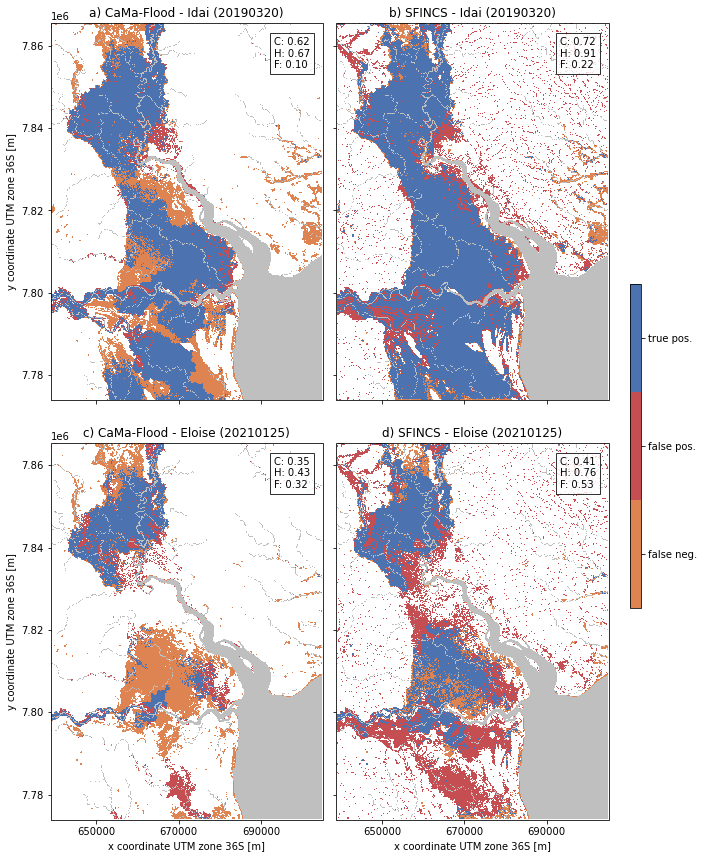

In [155]:
import matplotlib.pyplot as plt
from matplotlib import colors, patheffects
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
from string import ascii_lowercase

# read crs and utm zone > convert to cartopy
staticmaps = mod0.staticmaps
wkt = staticmaps.raster.crs.to_wkt()
if "UTM zone " not in wkt:
    raise ValueError("Model CRS UTM zone not found.")
utm_zone = staticmaps.raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
extent = np.array(staticmaps.raster.box.buffer(100).total_bounds)[[0, 2, 1, 3]]
props = dict( facecolor='w', alpha=0.8)

ann_kwargs = dict(
    xytext=(3, 3),
    textcoords="offset points",
    zorder=4,
    path_effects=[
        patheffects.Stroke(linewidth=3, foreground="w"),
        patheffects.Normal(),
    ],
)

fig, axs = plt.subplots(
    nrows=2, figsize=(10,15),
#     nrows=1, figsize=(10,8),
    ncols=2,
    subplot_kw={'projection': utm},
    
    sharex = True, sharey=True
)
axs = axs.flatten()
d = {
    'sfx': 'SFINCS',
    'cmf': 'CaMa-Flood',
    dates[0]: 'Idai',
    dates[1]: 'Eloise',
}

for row, tstr in enumerate(dates):
    for col, mod in enumerate(['cmf', 'sfx']):
        i = int(row*2 + col)
        ax = axs[i]
        da_cm = res[mod][tstr]
        da_skill = scores[mod][tstr]
        hr, csi, fr = da_skill['H'].item(), da_skill['C'].item(), da_skill['F'].item()

        da_mask.where(da_mask).plot(ax=ax, cmap='gray', add_colorbar=False, alpha=0.5)
        cs = da_cm.where(da_cm>0).plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
#         if row == 0:
#             gdf_pnts.to_crs(da_cm.raster.crs).plot(ax=ax)
#         for label, gdf_row in gdf_pnts.to_crs(da_cm.raster.crs).iterrows():
#             x, y = gdf_row.geometry.x, gdf_row.geometry.y
# #             ax.plot(x, y, color='k', marker='o')
#             ax.annotate(label, xy=(x, y), **ann_kwargs)
            
        ax.yaxis.set_visible(True)
        ax.xaxis.set_visible(True)
        ax.text(0.82, 0.88, f'C: {csi:.2f}\nH: {hr:.2f}\nF: {fr:.2f}', transform=ax.transAxes, bbox=props)

        if col == 0:
            ax.set_ylabel(f"y coordinate UTM zone {utm_zone} [m]")
        else:
            ax.set_ylabel('')
        
        l = ascii_lowercase[i]
        ax.set_title(f'{l}) {d[mod]} - {d[tstr]} ({tstr})')
        if i >= len(axs)-2:
            ax.set_xlabel(f"x coordinate UTM zone {utm_zone} [m]")   
        else:
            ax.set_xlabel('')
            
ax.set_xticks(ax.get_xticks()[::2])
ax.set_extent(extent, crs=utm)
fig.subplots_adjust(wspace=0.05, hspace=0.06)

# # Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.93, 0.33, 0.015, 0.3])

# # Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='vertical', ticks=ticks)
cbar_ax.set_yticklabels(ticklabs)

plt.savefig(join('figs', f'obs_vs_sim_hmin25.png'), dpi=500, bbox_inches="tight")

## timeseries plots

In [ ]:
# read SFINCS waterlevels for combined idai + eloise runs for all forcing scenarios

mdir = r'../02_models/beira/sfincs/'
# IDAI runs < 10; eloise > 10
event, runs = 'idai', glob.glob(join(mdir, '03_0*'))
da_lst = []
names = []
for root in runs:
    mod = SfincsModel(root, mode='r')
    mod.read_results()
    da_lst.append(mod.results['zs'])
    names.append(basename(root)[6:])
da0 = xr.concat(da_lst, dim='run')
da0['run'] = xr.IndexVariable('run', names)

event, runs = 'eloise', glob.glob(join(mdir, '03_1*'))
da_lst = []
names = []
for root in runs:
    mod = SfincsModel(root, mode='r')
    mod.read_results()
    da_lst.append(mod.results['zs'])
    names.append(basename(root)[6:])
da1 = xr.concat(da_lst, dim='run')
da1['run'] = xr.IndexVariable('run', names)

da_sfx_zs = xr.concat([da0, da1], dim='time').round(2)

encoding = {'zs': {'zlib': True, 'dtype': 'float32'}}
da_sfx_zs.to_netcdf(join(mdir, f'zs_compound.nc'))


In [ ]:
# read SFINCS data
mdir = r'../02_models/beira/sfincs/'

da_sfx_zs = xr.open_dataarray(join(mdir, f'zs_compound.nc'), chunks={'run':1})
da_sfx_zs

In [ ]:
# read CMF waterlevels for combined idai + eloise runs
cmf_out = r'../02_models/beira/cmf/out/compound_rivdph_est_hc27_hp30'
da_cmf_zs = xr.open_mfdataset(join(cmf_out, '*', 'o_flddph*'), concat_dim='time')['flddph'].rename('zs')
da_cmf_zs = da_cmf_zs + ds_cmf['elevtn'].raster.reproject_like(da_cmf_zs)
da_cmf_zs

In [ ]:
# load timeseries data at obs points

da_cmf_zs0 = da_cmf_zs.isel(lon=cols, lat=rows).sel(time=trange).load() #.plot.line(x='time')
da_cmf_zs0['index'] = xr.IndexVariable('index', gdf_pnts.index.values)
# df_cmf = da_cmf_zs0.to_series.unstack(0)
# df_cmf.index = mdates.date2num(df_cmf.index)

da_sfx_zs0 = da_sfx_zs.sel(time=trange, run='htot_dis_precip').raster.sample(gdf_pnts).load()#.plot.line(x='time')
da_sfx_zs0['index'] = xr.IndexVariable('index', gdf_pnts.index.values)

In [ ]:
# plot 
n = 2
kwargs0 = dict(sharex=True, figsize=(9, n * 3))
fig, (ax, ax1) = plt.subplots(n, 1, **kwargs0)
colors = ['darkblue', 'darkgreen', 'lightblue', 'darkmagenta', 'orangered']

# df.index = mdates.date2num(df.index)
j = 0
for i in range(1,3):
    da_sfx_zs0.sel(index=i).plot.line(ax=ax, x='time', color=colors[j], label=f'loc {i} - SFINCS')
    da_cmf_zs0.sel(index=i).plot.line(ax=ax, x='time', color=colors[j], ls='--', label=f'loc {i} - CaMa-Flood')
    j += 1
ax.set_title('Buzi River')
ax.set_ylabel('waterlevel [m+EGM96]')
ax.set_xlabel('')
ax.legend(
    title="index",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    ncol=1,
)

for i in range(3,6):
    da_sfx_zs0.sel(index=i).plot.line(ax=ax1, x='time', color=colors[j], label=f'loc {i} - SFINCS')
    da_cmf_zs0.sel(index=i).plot.line(ax=ax1, x='time', color=colors[j], ls='--', label=f'loc {i} - CaMa-Flood')
    j += 1
ax1.set_title('Pungwe River')
ax1.set_ylabel('waterlevel [m+EGM96]')
ax1.legend(
    title="index",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    ncol=1,
)
ax1.set_xlim([da_sfx_zs0.time.values[0], da_sfx_zs0.time.values[-1]])

# use a concise date formatter for format date axis ticks
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)

plt.savefig(join('figs', f'sfincs_vs_cmf_timeseries_idai.png'), dpi=225, bbox_inches="tight")

In [ ]:
# gdf_pnts1 = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=[34.78024, 34.78508],y=[-19.82118, -19.83855]), crs=4326)
gdf_pnts1 = gdf_pnts.loc[[2,5],]
da_sfx_zs0 = da_sfx_zs.sel(time=trange).raster.sample(gdf_pnts1).load()#.plot.line(x='time')
da_sfx_zs0['index'] = xr.IndexVariable('index', gdf_pnts1.index.values)

n = da_sfx_zs0.index.size
kwargs0 = dict(sharex=True, figsize=(9, n * 3))
fig, axs = plt.subplots(n, 1, **kwargs0)

rm = {
    'htide_disclim_precip': 'Pluvial',
    'htide_dis_noprecip': 'Fluvial',
    'htot_disclim_noprecip': 'Coastal',
    'htot_dis_precip': 'Compound',
}
for i, idx in enumerate(gdf_pnts1.index):
    da0 = da_sfx_zs0.sel(index=idx).sel(run=list(rm.keys()))
    lines = da0.plot.line(x='time', ax=axs[i], add_legend=False)
    axs[i].set_ylabel('waterlevel [m+EGM96]')
    axs[i].set_title(f'loc {idx}')
    axs[i].set_xlabel('')
    if i == 0:
        axs[0].legend(
            lines,
            labels=list(rm.values()),
            title="scenarios",
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
            ncol=1,
        )
axs[-1].set_xlim([da_sfx_zs0.time.values[0], da_sfx_zs0.time.values[-1]])


### read & plot SFINCS runs (old)

In [ ]:
import glob
mdir = r'../02_models/beira/sfincs'
runs = glob.glob(join(mdir, '01_b*')) + glob.glob(join(mdir, '02*')) + glob.glob(join(mdir, '03_*'))
runs

In [ ]:

df = pd.DataFrame(columns=['csi', 'hit_rate', 'miss_rate', 'inf_mean', 'inf_max'], dtype=np.float32)
mods ={}
tstr = '20190321'
tstr = 'max'
mask, write, plot = False, False, False

for root in runs:

    name = basename(root)[3:]
    print(name)
    mod = SfincsModel(root, mode='r')
    mod.read_results()
    if tstr == 'max':
        da_hmax_fld = mod.results['hmax']
    else:
        da_hmax_fld = np.maximum(0, mod.results['zsmax'].sel(timemax=tstr) - mod.results['zb'])
        da_hmax_fld.raster.set_nodata(mod.results['hmax'].raster.nodata)
    if mask:
        da_hmax_fld = da_hmax_fld.where(~da_mask, mod.results['hmax'].raster.nodata)
    if mask or tstr != 'max':
        mod.set_results(da_hmax_fld, f'h{tstr}')
    if write and not isfile(join(mod.root, 'gis', f'h{tstr}.tif')):
        mod.write_raster(f'results.h{tstr}')
    
    csi, hit_rate, miss_rate, da_cm = skill(da_hmax_fld, da_obs, da_mask)
    df.loc[name, ['csi', 'hit_rate', 'miss_rate']] = csi, hit_rate, miss_rate
#     df.loc[name, 'inf_mean'] = float(mod.results['cuminf'].mean())
#     df.loc[name, 'inf_max'] = float(mod.results['cuminf'].max())
    mod.set_results(da_cm, f'cm{tstr}')
    mods[name] = mod
    
#     if plot:
    if not isfile(join(mod.root, 'figs', f'obs_vs_sim_{tstr}.png')):
        # fig, ax = mod.plot_basemap(fn_out=None, variable=None, bmap='sat', geoms=[], plot_bounds=False)
        fig, ax = mod.plot_basemap(fn_out=None, variable=None, bmap='', zoomlevel=12, geoms=[], plot_bounds=False)
#         ax.add_image(cimgt.Stamen(style='toner-background'), 11, cmap='gray', alpha=0.5)
        da_mask.where(da_mask).plot(ax=ax, cmap='gray', add_colorbar=False, alpha=0.5)
        p = da_cm.where(da_cm>0).plot(cmap=cmap, norm=norm, cbar_kwargs=dict(ticks=ticks, shrink=0.3, anchor=(0,0)))
        _ =p.colorbar.ax.set_yticklabels(ticklabs)
        ax.set_title(f'Observed vs simulated flood extent\n (HR = {hit_rate:0.2f}, CSI = {csi:0.2f})')
        if not os.path.isdir(join(mod.root, 'figs')):
            os.makedirs(join(mod.root, 'figs'))
        plt.savefig(join(mod.root, 'figs', f'obs_vs_sim_{tstr}.png'), dpi=225, bbox_inches="tight")
        plt.close()
    
    
df = df.round(3)
df.to_csv(join(mdir, f'sfincs_{tstr}_results.csv'))
df

In [ ]:
name, tstr = 'eloise', '20210125'
# name, tstr = 'idai', '20190321'
root = join(join(mdir, f'04_{name}'))
mod = SfincsModel(root, mode='r')
da_hmax_fld = np.maximum(0, mod.results['zsmax'].sel(timemax=tstr) - mod.results['zb'])
# mod = mods[name]
# da_cm = mod.results[f'cm{tstr}']
# csi, hit_rate = df.loc[name, ['csi', 'hit_rate']]
csi, hit_rate, miss_rate, da_cm = skill(da_hmax_fld, da_obs, da_mask)
da_cm.attrs = {}
da_cm.name = None

# fig, ax = mod.plot_basemap(fn_out=None, variable=None, bmap='sat', geoms=[], plot_bounds=False)
fig, ax = mod.plot_basemap(fn_out=None, variable=None, bmap='', zoomlevel=12, geoms=[], plot_bounds=False)
# ax.add_image(cimgt.Stamen(style='toner-background'), 11, cmap='gray', alpha=0.5)
da_mask.where(da_mask).plot(ax=ax, cmap='gray', add_colorbar=False, alpha=0.5)
p = da_cm.where(da_cm>0).plot(cmap=cmap, norm=norm, cbar_kwargs=dict(ticks=ticks, shrink=0.3, anchor=(0,0)))
_ =p.colorbar.ax.set_yticklabels(ticklabs)
ax.set_title(f'Observed vs simulated flood extent\n (HR = {hit_rate:0.2f}, CSI = {csi:0.2f})')
if not os.path.isdir(join(mod.root, 'figs')):
    os.makedirs(join(mod.root, 'figs'))
plt.savefig(join(mod.root, 'figs', f'obs_vs_sim_{tstr}.png'), dpi=225, bbox_inches="tight")

### read all SFINCS runs into single dataset for compound dynamic plots

In [ ]:
import glob
mdir = r'../02_models/beira/sfincs'
runs = glob.glob(join(mdir, '03_*'))
print(runs)
ts = pd.date_range('201903130000', '201903240000', freq='24H')
mods = {}
for root in runs:
    name = basename(root)[3:]
    mod = SfincsModel(root, mode='r')
    da_fld = np.maximum(0, mod.results['zsmax'] - mod.results['zb']).rename({'timemax': 'time'})
    mods[name] = da_fld.sel(time=ts, method='nearest').fillna(0).load()
#     mods[name] = np.maximum(mod.results['zsmax'], mod.results['zb']).sel(time=ts, method='nearest').load()
    mods[name].name = name
    mods[name].close()

da0 = xr.concat(mods.values(), dim='scen')
da0['scen'] = xr.IndexVariable('scen', list(mods.keys()))

da0 = da0.round(3).rename('flddph')
da0.to_netcdf('sfincs_compound1.nc', encoding={'flddph': {'zlib': True}})

In [ ]:
da_mask_int = mod0.staticmaps['rivmsk']
gdf = da_mask_int.raster.vectorize()
# gdf.boundary.plot()

In [ ]:
event, ts = 'idai', pd.date_range('201903140000', '201903220000', freq='24H')
event, ts = 'eloise', pd.date_range('202101190000', '202101270000', freq='24H')

mdir = r'../02_models/beira/sfincs/'

da0 = xr.open_dataarray(join(mdir, f'flddph_{event}.nc')).sel(time=ts, method='nearest').fillna(0)

In [ ]:
# append timemax to time dim
hmin = 0.25

da3 = da0.resample(time='3D').max('time')
da_max = da3.max('time').expand_dims('time')
da_max['time'] = xr.IndexVariable('time', [da0.time.max().values])
# fldmsk = da_max.sel(scen='01_htot_dis_precip').squeeze() > hmin
da = xr.concat([da3, da_max], dim='time').load()
da = da.where(da > hmin, 0).rename({'run': 'scen'})
da.chunk({'time':-1})

In [ ]:
# create SFINCS compound driver array
import matplotlib
import cartopy.io.img_tiles as cimgt
dh =  0.02

da_single_max = da.sel(scen=['htide_dis_noprecip', 'htot_disclim_noprecip', 'htide_disclim_precip', 'htide_disclim_noprecip']).max('scen')
compound_diff = (da.sel(scen='htot_dis_precip') - da_single_max).compute()
compound_diff.name = 'diff. in waterlevel\ncompound - max. single driver'
compound_diff.attrs.update(unit='m')

compound_mask = compound_diff > dh
surge_mask = da.sel(scen='htot_disclim_noprecip') > da.sel(scen=['htide_disclim_precip', 'htide_dis_noprecip']).max('scen')
discharge_mask = da.sel(scen='htide_dis_noprecip') > da.sel(scen=['htot_disclim_noprecip', 'htide_disclim_precip']).max('scen')
precip_mask = da.sel(scen='htide_disclim_precip') > da.sel(scen=['htot_disclim_noprecip', 'htide_dis_noprecip']).max('scen') 
precip_mask = np.logical_and(precip_mask, compound_diff>=0)
assert ~np.logical_and(precip_mask, surge_mask).any() and ~np.logical_and(discharge_mask, surge_mask).any() and ~np.logical_and(discharge_mask, precip_mask).any()

da_cmpnd = (
    xr.where(surge_mask, compound_mask+1, 0)
    + xr.where(discharge_mask, compound_mask + 3, 0)
    + xr.where(precip_mask, compound_mask + 5, 0)
).compute()
da_cmpnd.name = None

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors, patheffects
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
from string import ascii_lowercase
import datetime

# read crs and utm zone > convert to cartopy
staticmaps = mod0.staticmaps
wkt = staticmaps.raster.crs.to_wkt()
utm_zone = staticmaps.raster.crs.to_wkt().split("UTM zone ")[1][:3]
utm = ccrs.UTM(int(utm_zone[:2]), "S" in utm_zone)
extent = np.array(staticmaps.raster.box.buffer(100).total_bounds)[[0, 2, 1, 3]]

cmap = matplotlib.cm.get_cmap('tab20c')
levels = np.arange(1,8)
colors = np.array(cmap.colors)[[2,0,14,12,10,8]]
cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)


dates = compound_diff.time
n = len(dates)
fig, axs = plt.subplots(
#     nrows=2, figsize=(10,15),
    nrows=2, figsize=(4.5*n, 12),
    ncols=n,
    subplot_kw={'projection': utm},
    sharex = True, sharey=True, 
)
axs = axs.flatten()

for row, time in enumerate(dates):

    # dh
    da_t= compound_diff.sel(time=time)
    if row == len(dates)-1:
        tstr = 'total'
    else:
        t1 = da_t.time + int(3*86400*1e9) # nano sec
        tstr0 = da_t.time.dt.strftime("%d").item()
        tstr1 = t1.dt.strftime("%d %b %Y").item()
        tstr = f'{tstr0}-{tstr1}'
        
    i = row
    dep_mask.where(dep_mask).plot(ax=axs[i], cmap='gray', add_colorbar=False, alpha=0.5)
    ckwargs = dict(cmap='seismic', vmin=-0.25, vmax=0.25)
    cs = da_t.where(np.abs(da_t)>dh).plot(ax=axs[i], add_colorbar=False, **ckwargs)
    gdf.boundary.plot(ax=axs[i], ls='--', lw=0.5, color='k', alpha=0.5)
    
    # driver
    da_c = da_cmpnd.sel(time=time)
    j = row + n
    dep_mask.where(dep_mask).plot(ax=axs[j], cmap='gray', add_colorbar=False, alpha=0.5)
    p = da_c.where(da_c>0).plot(ax=axs[j], cmap=cmap, norm=norm, add_colorbar=False)
    gdf.boundary.plot(ax=axs[j], ls='--', lw=0.5, color='k', alpha=0.5)

    axs[i].set_title(tstr)
    axs[j].set_title('')
    axs[i].set_extent(extent, crs=utm)
    axs[j].set_extent(extent, crs=utm)

    if row == 0:
        axs[i].yaxis.set_visible(True)
        axs[i].set_ylabel(f"y coordinate UTM zone {utm_zone} [m]")
        axs[j].yaxis.set_visible(True)
        axs[j].set_ylabel(f"y coordinate UTM zone {utm_zone} [m]")
    axs[j].xaxis.set_visible(True)
    axs[j].set_xlabel(f"x coordinate UTM zone {utm_zone} [m]")

axs[j].set_xticks(axs[j].get_xticks()[1::2])
fig.subplots_adjust(wspace=0.03, hspace=0.05)

# add colormap dh
pos0 = axs[i].get_position() # get the original position 
cax = fig.add_axes([pos0.x1 + 0.01, pos0.y0 + pos0.height*0.15, 0.015, pos0.height*0.7])
label = 'diff. waterlevel [m]\ncompound - max. single driver'
cbar=fig.colorbar(cs, cax=cax, orientation='vertical', label=label, extend='both')

# Add a colorbar drivers
pos1 = axs[j].get_position() # get the original position 
cbar_ax = fig.add_axes([pos1.x1 + 0.01, pos1.y0 + pos0.height*0.25,  0.05, pos0.height*0.5] )
cm = np.arange(1,7).reshape((3,2))
cbar_ax.imshow(cm, cmap=cmap, norm=norm, aspect='auto')
cbar_ax.yaxis.tick_right()
cbar_ax.set_yticks([0,1,2])
cbar_ax.set_yticklabels(['coastal', 'fluvial', 'pluvial'], va='center', rotation=90)
cbar_ax.set_xticks([0,1])
cbar_ax.set_xticklabels(['single', 'compound'], ha='center', rotation=60)

plt.savefig(join('figs', f'sfincs_{event}_compound_zsmax_3d_v1.png'), dpi=225, bbox_inches="tight")

In [ ]:
# simulation waterdepth run plot
name = '01_htot_dis_precip'
for time in da.time:
    t = time.dt.strftime("%Y-%m-%d %H:%M").item()
    tstr = time.dt.strftime("%Y%m%dT%H%M").item()
    # sfincs
#     fn_out = join(mdir, f'03_{name}', 'figs', f'h{tstr}.png')
#     da_t = da.sel(scen=name, time=time)
    # cmf
    root = join('../02_models/beira/sfincs/', f'03_{name}')
    fn_out = join(root, 'figs', f'h{tstr}.png')
    da_t = mods[name].sel(time=time)
    print(t)
    
    fig, ax = mod.plot_basemap(fn_out=None, variable=None, bmap='sat', geoms=[], plot_bounds=False)
#     ax.add_image(cimgt.Stamen(style='toner-background'), 11, cmap='gray', alpha=0.5)
    da_mask.where(da_mask).plot(ax=ax, cmap='gray', add_colorbar=False, alpha=0.5)
    p = da_t.where(da_t>0).plot(cmap='BuPu', vmin=0, vmax=5, cbar_kwargs=dict(shrink=0.5, anchor=(0,0)))
    gdf.boundary.plot(ls='--', lw=0.5, color='k', alpha=0.5, ax=ax)
    ax.set_title(f'Flood depth {t}')
    plt.savefig(fn_out, dpi=225, bbox_inches="tight")
    plt.close()

In [ ]:
# 2 variable compound plot
import matplotlib
import cartopy.io.img_tiles as cimgt
dh =  0.01
hmin = 0.20

da = da.where(da.sel(scen='01_htot_dis_precip') > hmin, 0)
da_single_max = da.sel(scen=['04_htide_dis_noprecip', '06_htot_disclim_noprecip']).max('scen')
da_max = da.max('scen')
mask = da_max > hmin

da_discharge = da.sel(scen='02_htot_dis_noprecip')  > (da_single_max + dh)
da_surge = da.sel(scen='02_htot_dis_noprecip')  > (da_single_max + dh)

compound_mask = da.sel(scen='01_htot_dis_precip') > (da_single_max + dh)
surge_mask = da.sel(scen='06_htot_disclim_noprecip') > da.sel(scen='04_htide_dis_noprecip')
discharge_mask = da.sel(scen='04_htide_dis_noprecip') > da.sel(scen='06_htot_disclim_noprecip')

da_cmpnd = (
    xr.where(surge_mask, da_surge+1, 0)
    + xr.where(discharge_mask, da_discharge+5, 0)
).where(mask, 0)
da_cmpnd.name = None
cmap0 = matplotlib.cm.get_cmap('tab20c')
levels = np.arange(1,8)
colors = np.array(cmap0.colors)[[2,0,10,8,14,12]]
cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)
ticks = np.array(levels[:-1])+np.diff(levels)/2.
ticklabs = ['coastal', 'coastal - compound', 'pluvial', 'pluvial - compound', 'fluvial', 'fluvial - compound']

fig, ax = mod.plot_basemap(fn_out=None, variable=None, bmap='', zoomlevel=12, geoms=[], plot_bounds=False)
ax.add_image(cimgt.Stamen(style='toner-background'), 11, cmap='gray', alpha=0.5)
p = da_cmpnd.where(da_cmpnd>0).plot(cmap=cmap, norm=norm, cbar_kwargs=dict(ticks=ticks, shrink=0.5, anchor=(0,0)))
gdf.boundary.plot(ls='--', lw=0.5, color='k', alpha=0.5, ax=ax)
_ =p.colorbar.ax.set_yticklabels(ticklabs)
ax.set_title(f'Flood drivers maximum water depth cyclone Idai')
plt.savefig(join('figs', f'drivers2_{tstr}.png'), dpi=225, bbox_inches="tight")